In [1]:
%load_ext autoreload
%autoreload 
import sys; import os
sys.path.append(os.path.abspath('../'))
from src import data_handlers, matrix_ops
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from scipy import sparse

# Load Preprocessed DataFrames

Load the prepocessed Data Frames provided by:
- US Government 
- Chair of Financial Management and Capital Markets 

Preprocessing includes:
- Dropping duplicates
- Apply Regex patterns
- Correction of the addresses

In [2]:
usa_df = pd.read_csv('../processed/processed_usa.csv', low_memory = False)
usa_df.shape

(6442676, 29)

##  US Spending DF

In [5]:
usa_df.head()

,recipient_duns,recipient_name,recipient_doing_business_as_name,recipient_parent_duns,recipient_parent_name,recipient_country_code,recipient_country_name,recipient_address_line_1,recipient_address_line_2,recipient_city_name,...,recipient_zip_code,recipient_zip_last_4_code,recipient_foreign_city_name,recipient_foreign_province_name,recipient_foreign_postal_code,clean_recipient_name,clean_recipient_parent_name,clean_recipient_doing_business_as_name,recipient_address_line_fixed,recipient_state_fixed
0,139032531,ISOTEK SYSTEMS LIMITED LIABILITY COMPANY,NaN,139032531,ISOTEK SYSTEMS LLC,UNITED STATES,NaN,700 S ILLINOIS AVE,SUITE A102,OAK RIDGE,...,NaN,NaN,NaN,NaN,NaN,ISOTEK SYSTEMS LLC,NaN,NaN,700 SAN ILLINOIS AVENUE SUITE A102,TENNESSEE
1,168599863,TRUSTON TECHNOLOGIES INCORPORATED,NaN,168599863,TRUSTON TECHNOLOGIES INC.,UNITED STATES,NaN,102 RUE DU PAIN,NaN,BROUSSARD,...,NaN,NaN,NaN,NaN,NaN,TRUSTON TECHNOLOGIES INC,NaN,NaN,102 RUE DU PAIN,LOUISIANA
2,005144808,"PALOMAR PRODUCTS, INC.",NaN,043190826,ESTERLINE TECHNOLOGIES CORP,USA,UNITED STATES,23042 ARROYO VISTA,NaN,RCHO STA MARG,...,NaN,NaN,NaN,NaN,NaN,PALOMAR PRODUCTS INC,ESTERLINE TECHNOLOGIES CORP,NaN,23042 ARROYO VISTA,CALIFORNIA
3,118759695,"LCL ELECTRONICS, INC.",NaN,118759695,LCL ELECTRONICS INC.,USA,UNITED STATES,8148 INDUSTRIAL PARK RD,NaN,BAXTER,...,NaN,NaN,NaN,NaN,NaN,LCL ELECTRONICS INC,NaN,NaN,8148 INDUSTRIAL PARK ROAD,MINNESOTA
4,174786913,NORTHROP GRUMMAN SHIP SYSTEMS INCORPORATED,NaN,967356127,NORTHROP GRUMMAN CORPORATION,USA,UNITED STATES OF AMERICA,1000 ACCESS RD,NaN,PASCAGOULA,...,NaN,NaN,NaN,NaN,NaN,NORTHROP GRUMMAN SHIP SYSTEMS INC,NORTHROP GRUMMAN CORP,NaN,1000 ACCESS ROAD,MISSISSIPPI


## Chair of Financial Management and Capital Markets DF


In [4]:
chair_df = pd.read_csv('../processed/processed_chair.csv', low_memory = False)

In [5]:
chair_df.head()

,gvkey,conm,conml,state,add1,add2,add3,add4,addzip,clean_conm,add_fixed,state_fixed
0,1000,A & E PLASTIK PAK INC,A & E Plastik Pak Inc,NaN,NaN,NaN,NaN,NaN,NaN,A&E PLASTIK PAK INC,NaN,NaN
1,1001,A & M FOOD SERVICES INC,A & M Food Services Inc,OK,1924 South Utica Avenue,NaN,NaN,NaN,94104,A&M FOOD SVCS INC,1924 SOUTH UTICA AVENUE,OKLAHOMA
2,1002,AAI CORP,AAI Corp,MD,124 Industry Lane,NaN,NaN,NaN,21030-0126,AAI CORP,124 INDUSTRY LANE,MARYLAND
3,1003,A.A. IMPORTING CO INC,A.A. Importing Co Inc,MO,7700 Hall Street,NaN,NaN,NaN,63125,AA IMPORTING CO INC,7700 HALL STREET,MISSOURI
4,1004,AAR CORP,AAR Corp,IL,"One AAR Place, 1100 North Wood Dale Road",NaN,NaN,NaN,60191,AAR CORP,1 AAR PLACE 1100 NORTH WOOD DALE ROAD,ILLINOIS


# Candidate Selection

To detect similarity of two documents from the 2 datasets, we vectorized the company names in dataframes.

With the preprocessed datasets, we first create a vocabulary that consists of every single word included in company names. These company names are taken from preprocessed names - `conm` in the CFMCM dataset, `recipient_name`, `recipient_parent_name`, `recipient_doing_business_as_name` in the USA Spending dataset.

Then, we represent each company name with a vector using the vocabulary we have. Once we convert our names to vectors, we calculate how similar they are, using the cosine similary measure.

In addition to similarities in names, we also take into account the similarities in geolocations. We use address information to accomplish this.

At the end, we combine name similarity and geolocation similarity to compute the final similarity score.

##  Vectorization 

In vectorization we aim to represent each company name with a vector. In this vector, only cells that correspond to the words included in the name should have non-zero values. The rest of the vector should be zero.

If we set all non-zero values to 1, then each word would have the same importance when calculating the name similarity (i.e. the similarity between the vectors). On the contrary, we want to give each word a weigth that corresponds to its importance. We calculate this "importance" using tf-idf.

In the tf-idf (Term Frequency - Inverse Document Frequency) measure, terms that occur frequently have a smaller effect than the ones that occur rarely. In practice, this forces common words like 'inc' or 'corp' to have a smaller effect on the similarity scores whereas company-specific words such as 'AT&T' has a higher weigth.

To train the vectorizer we used a corpus that includes unique preprocessed company names in the two datasets.

At the end, for each company name, we create a weighted sparse vector with size equal to vocabulary's.

In [6]:
companies = data_handlers.get_unique_company_names(usa_df)
companies.shape

(1702988,)

In [70]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern= r'\S+')
vectorizer.fit(pd.concat([chair_df.clean_conm, pd.Series(companies)]).unique())
tfidf = vectorizer.transform(chair_df.clean_conm)
tfidf_USA = vectorizer.transform(companies)

### IDF scores of the most common words

As expected, weights of the most common words are the smallest.

In [71]:
df_idf = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"])
df_idf = df_idf.sort_values(by=['idf_weights'])
df_idf.head(20)

,idf_weights
inc,2.214988
llc,2.880707
and,3.314485
of,3.922997
co,4.326562
corp,4.413637
svcs,4.575430
farms,4.744378
the,4.745162
ltd,4.902366


# IDF Distribution of the Vocabulary
Most of the company names includes some company specific words. This results can also be seen in the distribution of the idfs (inverse document frequencies). Most of our vocabulary consists of words that occur rarely, thus have high idf (inverse document frequency).

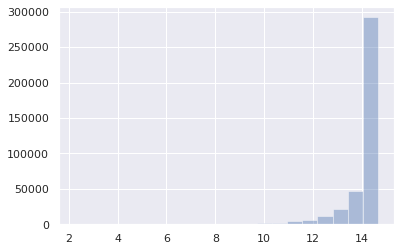

In [72]:
sns.distplot(vectorizer.idf_, kde=False, bins=20)

## Calculate Cosine Similarity Matrix

After we vectorized the company names we calculated the cosine similarity between each company name in the CFMCF (Chair of Financial Management and Capital Markets) Dataset and the US Government Dataset.

The resulting cosine similarity matrix has massive size (28k to 2 million). To be able to store it in the memory we selected candidates that have a cosine similarity larger than a given threshould (0.4) and we stored the result in a sparse matrix to eliminate zeros. 

In [73]:
THRES = 0.4
cosine_similarities, max_similarities = matrix_ops.get_cosine_similarities(tfidf, tfidf_USA, THRES)

/home/sirin/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


0 of 28816 documents are calculated
1000 of 28816 documents are calculated
2000 of 28816 documents are calculated
3000 of 28816 documents are calculated
4000 of 28816 documents are calculated
5000 of 28816 documents are calculated
6000 of 28816 documents are calculated
7000 of 28816 documents are calculated
8000 of 28816 documents are calculated
9000 of 28816 documents are calculated
10000 of 28816 documents are calculated
11000 of 28816 documents are calculated
12000 of 28816 documents are calculated
13000 of 28816 documents are calculated
14000 of 28816 documents are calculated
15000 of 28816 documents are calculated
16000 of 28816 documents are calculated
17000 of 28816 documents are calculated
18000 of 28816 documents are calculated
19000 of 28816 documents are calculated
20000 of 28816 documents are calculated
21000 of 28816 documents are calculated
22000 of 28816 documents are calculated
23000 of 28816 documents are calculated
24000 of 28816 documents are calculated
25000 of 2881

### Load cosine similarity matrix

In [7]:
cosine_similarities  = sparse.load_npz('../processed/cosine_similarities.npz')
max_similarities = np.load('../processed/max_similarities.npy')
cosine_similarities

<28816x1702988 sparse matrix of type '<class 'numpy.float64'>'
	with 3844252 stored elements in Compressed Sparse Row format>

## Distribution of the Highest Cosine Similarities per Chair Company Name
After the preprocessing we see the number of exact matches as high as 3 thousand. 

Another observetion is that in the chair dataset there are company names for which only low quality matches exist. 

An example of a such case is having no company name in the US Government datasets that matches the name in the Chair Dataset but having companies that have same company type as 'inc'. In such a case, since 'inc' has very low IDF, the cosine similarity will also be very low even for the best match.

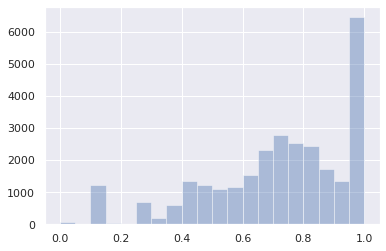

In [8]:
sns.set(); np.random.seed(0)
sns.distplot(max_similarities, kde=False, bins=20)

## Selection of the Best Candidates
After calculating the cosine similarity between the companies, we end up with an average of 200 candidates for each company in the CFMCF dataset.

In our selection of the best candidate we intruduce a bonus point on top of the cosine similarity measure based on __geolocation__.
The default bonuses that we selected are as:
- same state bonus = 0.05
- same zip bonus = 0.1
- same address bonus = 0.3

Afterwards the selection of the best candidate is done using this combined score metric.

In [11]:
best_matches = matrix_ops.get_best_candidates(chair_df, usa_df, cosine_similarities, companies, 
                                              zip_bonus = 0.1, state_bonus=0.05, address_bonus= 0.3)

0 of 28816 documents are calculated


/home/sirin/.local/lib/python3.6/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/sirin/.local/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


1000 of 28816 documents are calculated
2000 of 28816 documents are calculated
3000 of 28816 documents are calculated
4000 of 28816 documents are calculated
5000 of 28816 documents are calculated
6000 of 28816 documents are calculated
7000 of 28816 documents are calculated
8000 of 28816 documents are calculated
9000 of 28816 documents are calculated
10000 of 28816 documents are calculated
11000 of 28816 documents are calculated
12000 of 28816 documents are calculated
13000 of 28816 documents are calculated
14000 of 28816 documents are calculated
15000 of 28816 documents are calculated
16000 of 28816 documents are calculated
17000 of 28816 documents are calculated
18000 of 28816 documents are calculated
19000 of 28816 documents are calculated
20000 of 28816 documents are calculated
21000 of 28816 documents are calculated
22000 of 28816 documents are calculated
23000 of 28816 documents are calculated
24000 of 28816 documents are calculated
25000 of 28816 documents are calculated
26000 of 

In [22]:
# remove .0 from the end of the duns addresses ex: 012313.0 -> 012313
best_matches.recipient_duns = best_matches.recipient_duns.astype('str').str.replace('.0$', '').replace('nan',np.nan)

## Save Results

In [22]:
print(f'We managed to match { best_matches.score.dropna().shape[0]} matches out of { chair_df.shape[0] } company names.')
print(f'{selections.shape[0]} of these pass the similarity score threshold of {QUALITY_THRES}.')

We managed to match 25961 matches out of 28816 company names.
9792 of these pass the similarity score threshold of 0.8.


In [23]:
best_matches.dropna(how='all').to_csv('../results/matching_table_v2.csv')
selections.to_csv('../results/matching_table_with_threshold_v2.csv')

## Load Results

In [9]:
best_matches = pd.read_csv('../results/matching_table_v2.csv')
selections = pd.read_csv('../results/matching_table_with_threshold_v2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (36) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Cosine Similarity Scores Distribution of the Best Candidates

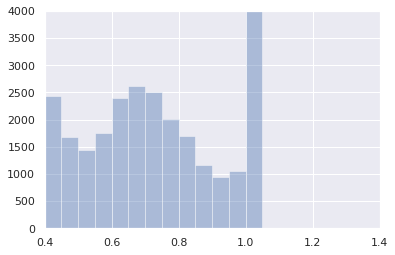

In [11]:
g = sns.distplot(list(best_matches.cos_sim.dropna()), kde=False,bins=np.arange(0, 1.41, 0.05))
_ = g.set(ylim=(0, 4000), xlim=(0.4,1.4))

## With Bonus Scores Distribution of the Best Candidates
We see a shift in scores due to the bonus points given by geolocation similarities

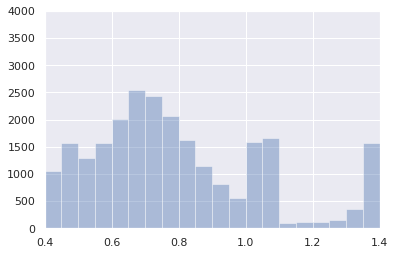

In [12]:
g = sns.distplot(list(best_matches.score.dropna()), kde=False, bins=np.arange(0, 1.41, 0.05))
_ = g.set(ylim=(0, 4000), xlim=(0.4,1.4))

## Random Selection of the Best Candidates

In [27]:
columns = ['conm','recipient_name','recipient_parent_name','state_fixed',
           'recipient_state_fixed','cos_sim','score','matched_by_parent_name']


best_matches[columns].dropna(how='all').sample(10)

,conm,recipient_name,recipient_parent_name,state_fixed,recipient_state_fixed,cos_sim,score,matched_by_parent_name
12082,NV5 HOLDINGS INC,HOLDINGS INC,NaN,FLORIDA,MARYLAND,0.432001,0.000000,False
7839,TECHNICOM INTERNATIONAL INC,TECHNICOM,NaN,CONNECTICUT,NaN,0.914540,0.914540,False
4410,SEARS HOLDINGS CORP,SEARS HOLDINGS CORPORATION,SEARS HOLDINGS CORPORATION,ILLINOIS,ILLINOIS,1.000000,1.350000,False
19332,CELLU TISSUE HOLDINGS INC,"BIO-TISSUE, INC.","BIO-TISSUE, INC.",GEORGIA,FLORIDA,0.456795,0.456795,True
988,BERG ENTERPRISES INC,"BERG ENTERPRISES, INC.","BERG ENTERPRISES, INC.",NEW JERSEY,ARIZONA,1.000000,1.000000,True
7361,SONAR RADIO CORP,SONAR,SONAR ASSURANCES,FLORIDA,NaN,0.797931,0.797931,False
23605,SUPERMEDIA INC,SUPERMEDIA LLC,SUPERMEDIA LLC,TEXAS,TEXAS,0.968596,1.018596,False
11072,TEMPLETON GLOBAL INCOME FUND,TEMPLETON FIRE DEPARTMENT,NaN,CALIFORNIA,CALIFORNIA,0.512519,0.562519,False
17882,99 CENTS ONLY STORES,99 CENTS N UP GIFTS STORE,NaN,CALIFORNIA,CALIFORNIA,0.512078,0.562078,False
4039,ISSC INDL SOLID STATE CONTRL,I S S C INCORPORATED,I S S C INC,PENNSYLVANIA,WASHINGTON,0.534403,0.000000,False


## Random Selection of the Best Candidates with Score Threshold

In [29]:
QUALITY_THRES = 0.8
selections = best_matches[best_matches.score>QUALITY_THRES]
selections[columns].sample(10)

,conm,recipient_name,recipient_parent_name,state_fixed,recipient_state_fixed,cos_sim,score,matched_by_parent_name
4670,LEADER INTL INDUSTRIES INC,LEADER MANUFACTURING INCORPORATED,LEADER INTERNATIONAL CORPORATION,NaN,WASHINGTON,0.820623,0.820623,True
5472,VALUE PROPERTY TRUST,"PROPERTY VALUE, INC.",PROPERTY VALUE INC.,NEW JERSEY,UTAH,0.894945,0.894945,True
23055,CHIPOTLE MEXICAN GRILL INC,CHIPOTLE MEXICAN GRILL INCORPORATED,CHIPOTLE MEXICAN GRILL INC.,COLORADO,CALIFORNIA,1.000000,1.000000,True
11585,GZA GEOENVIRONMENTAL TECH IN,GZA GEOENVIRONMENTAL INC,GZA GEOENVIRONMENTAL TECHNOLOGIES INC.,MASSACHUSETTS,MASSACHUSETTS,0.893808,1.243808,False
16804,CONCENTRA CORP,"CONCENTRA, INC","CONCENTRA, INC",MASSACHUSETTS,MASSACHUSETTS,0.927051,0.977051,False
20968,HANDSPRING INC,"HANDSPRING, INC","HANDSPRING, INC",CALIFORNIA,CALIFORNIA,1.000000,1.350000,False
13982,PHILIP SERVICES CORP,PHILIP SERVICES CORPORATION,PSC LLC,TEXAS,TEXAS,1.000000,1.050000,False
4906,MACANDREWS & FORBES,"AM GENERAL, LLC",MACANDREWS & FORBES HOLDINGS INC.,NEW YORK,INDIANA,0.932824,0.932824,True
3527,GRACO INC,GRACO INC.,NaN,MINNESOTA,MINNESOTA,1.000000,1.050000,False
7165,SEARS INDUSTRIES INC,SEARS,NaN,GEORGIA,GEORGIA,0.854964,0.904964,False


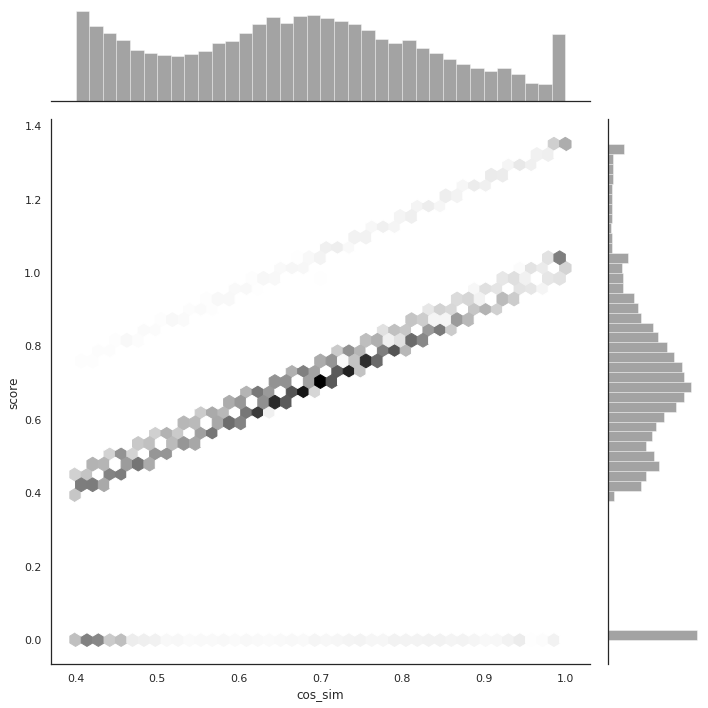

In [25]:
fig_data = best_matches[best_matches.cos_sim<1]

with sns.axes_style("white"):
    sns.jointplot(x=fig_data.cos_sim, y=fig_data.score, kind="hex", color="k", height = 10);